In [1]:
import sys
from pathlib import Path
project_root = Path().cwd().resolve().parent
sys.path.insert(0, str(project_root))

In [2]:
import os, path_config, sqlite3

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [3]:
target_dir_list = ['bimodal_topic_bilstm_proxy_v2_073', 'multimodal_bilstm_v2_068', 'multimodal_proxy_v2_052', 'multimodal_topic_bilstm_proxy_v2_075',
                    'multimodal_topic_bilstm_v2_2_072', 'multimodal_topic_proxy_v2_052']

In [4]:
db_path_list = [os.path.join(path_config.ROOT_DIR, 'checkpoints_optuna', dir_name, 'logs', 'optuna_study.db') for dir_name in target_dir_list]

In [46]:
def fetch_from_db(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k not in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k in ['use_text_proj', 'use_attention']:
        best_hyperparams_dict[k] = True if v==0.0 else False
      elif k in ['num_layers', 'bilstm_num_layers']:
        best_hyperparams_dict[k] = int(v)
      else:
        best_hyperparams_dict[k] = v

  cursor.execute('''
    SELECT value
    FROM trial_values
    ORDER BY value DESC
    LIMIT 1
  ''')
  best_f1 = cursor.fetchone()[0]
  
  return best_hyperparams_dict, best_f1

def fetch_from_db_2(db_path):
  con = sqlite3.connect(db_path)
  cursor = con.cursor()
  cursor.execute('''
    SELECT param_name, param_value 
    FROM trial_params
    WHERE trial_id = (
      SELECT trial_id
      FROM trial_values
      ORDER BY value DESC
      LIMIT 1
    );
  ''')
  best_hyperparams_list = cursor.fetchall()
  best_hyperparams_dict = {}

  for k, v in best_hyperparams_list:
    if k in ['batch_size', 'focal_alpha', 'focal_gamma', 'lr', 'optimizer', 'weight_decay']:
      if k == 'optimizer':
        v = 'Adam' if v==0 else 'AdamW' if v==1 else 'MomentumSGD'
      elif k == 'batch_size':
        v = 4 if v==0 else 8
      best_hyperparams_dict[k] = v
  
  return best_hyperparams_dict

In [47]:
params_dict = {}
params_dict_2 = {}
f1_dict = {}

for dir_name, db_path in zip(target_dir_list, db_path_list):
  model_name = dir_name.split('_v2')[0]
  best_hyperparams_dict, best_f1 = fetch_from_db(db_path)
  best_hyperparams_dict2 = fetch_from_db_2(db_path)
  params_dict[model_name] = best_hyperparams_dict
  params_dict_2[model_name] = best_hyperparams_dict2
  f1_dict[model_name] = best_f1

In [48]:
keys_to_index = {
  'multimodal_proxy':'Baseline',
  'multimodal_topic_proxy':'Baseline_Topic',
  'multimodal_bilstm':'BiLSTM_GAT',
  'multimodal_topic_bilstm':'BiLSTM_Topic_GAT',
  'multimodal_topic_bilstm_proxy':'TT-GAT',
  'bimodal_topic_bilstm_proxy':'Bimodal TT-GAT'
}

n_params_dict = {
  keys_to_index[k]:v
  for k,v in params_dict.items()
}
n_params_dict_2 = {
  keys_to_index[k]:v
  for k,v in params_dict_2.items()
}
n_f1_dict = {
  keys_to_index[k]:v
  for k,v in f1_dict.items()
}

params_df = pd.DataFrame.from_dict(n_params_dict, orient='index')
params_df_2 = pd.DataFrame.from_dict(n_params_dict_2, orient='index')
f1_df = pd.DataFrame.from_dict(n_f1_dict, orient='index', columns=['F1-score'])


order = ['Baseline', 'Baseline_Topic', 'BiLSTM_GAT', 'BiLSTM_Topic_GAT', 'TT-GAT', 'Bimodal TT-GAT']

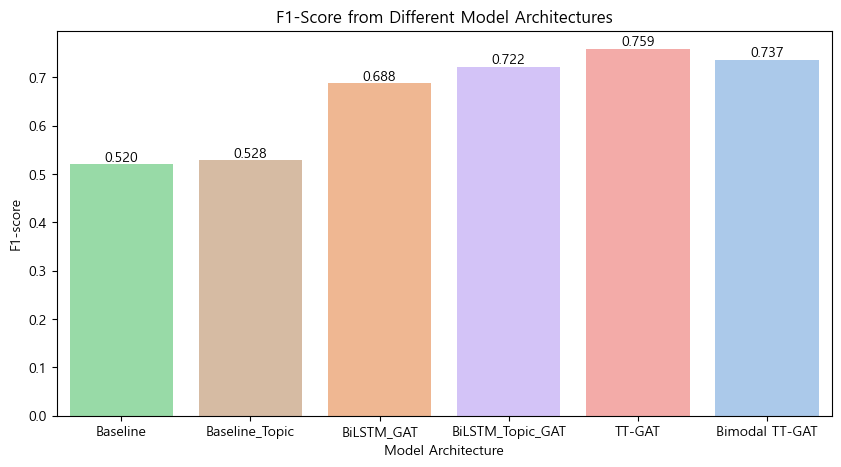

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(f1_df, x=f1_df.index, y='F1-score', order=order, palette='pastel', hue=f1_df.index, legend=False)
for p in ax.patches:
  ax.text(p.get_x() + p.get_width() / 2, # x 좌표 # type: ignore
          (p.get_y() + p.get_height())*1.01 , # y 좌표 # type: ignore
          f"{p.get_height():.3f}", # type: ignore
          ha='center')
plt.title("F1-Score from Different Model Architectures")
plt.xlabel('Model Architecture')
plt.savefig(os.path.join(path_config.ROOT_DIR, 'graph_explanation', 'F1-score_result.png'), dpi=400)
plt.show()

In [50]:
params_df.to_csv(os.path.join(path_config.ROOT_DIR, 'graph_explanation', 'HPO_Hyperparams_result.csv'))
params_df_2.to_csv(os.path.join(path_config.ROOT_DIR, 'graph_explanation', 'HPO_Hyperparams_result2.csv'))